# Painter by Numbers Kaggle Challenge (Data Exploration)
In this challenge, the goal is to train a model that is able to tell if two artworks were painted by the same artist.
The dataset provided originates mostly from the WikiArt.org dataset, and its use for data mining is considered fair use.

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image, ImageFile
import glob
import cv2
from einops import rearrange

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

#### First we use the training info file to organize the images in folders corresponding to the labels that identify their artists.

In [3]:
# Import dataset information
train_info = pd.read_csv('train_info.csv')

# Sort the rows according to file name
train_info = train_info.sort_values('filename')

# Create integer labels for each unique artist
artists = train_info['artist'].unique()
id2artist = dict(enumerate(artists))
artist2id = dict(zip(artists, range(len(artists))))

# Replace artist hashed names by their respective integer labels
train_info['artist'] = train_info.apply(lambda row: artist2id[row['artist']], axis=1)

# Sort rows by artist
train_info = train_info.sort_values(['artist', 'filename'])

In [ ]:
# Get labels and the labeling of each image in the training set
labels = train_info['artist'].unique()
labeling = train_info[['filename', 'artist']]

# Organize images in their respective class folders
for label in labels:
    os.mkdir(os.path.join('train', str(label)))
    
for row in labeling.values.tolist():
    os.rename(os.path.join('train', row[0]), os.path.join('train', str(row[1]), row[0]))

#### Then we iterate through the images to enrich the dataset metadata.

In [53]:
transform = transforms.Compose([transforms.ToTensor()])

# Create own collate function to accommodate images of different sizes
def collate_fn(batch):
    data = [item[0] for item in batch]
    labels = torch.LongTensor([item[1] for item in batch])
    return [data, labels]
    
dataset = datasets.ImageFolder('train', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [56]:
# Compute the means of the images as well as their dimensions
dims = []
means = []
for data, labels in tqdm(data_loader):
    for image in data:
        #dims.append(image.size()[1:])
        #means.append(torch.mean(image, (1,2)))

mean = torch.from_numpy(train_info['mean'].mean())

# Compute the mean squared difference to the mean of the dataset for every image (ised to compute dataset standard deviation)
squares_means = []
for data, labels in tqdm(data_loader):
    for image in data:
        squares_means.append(torch.mean(torch.square(rearrange(image, 'c h w -> h w c') - mean), (0,1)))

tensor([0.5201, 0.4664, 0.4038])


100%|██████████████████████████████████████████████████████████████████████████| 2483/2483 [2:05:50<00:00,  3.04s/it]


In [57]:
# Create new columns in the metadata for image dimension and channel mean
train_info['dimensions'] = [tuple(dim) for dim in dims]
train_info['pixels'] = [x * y for (x,y) in dims]
train_info['mean'] = [mean.numpy() for mean in means]
train_info['mean_squared_deviation'] = [mean.numpy() for mean in squares_means]


In [51]:
# Save metadata to new .csv file
train_info.to_csv('train_info_enriched.csv', index=False)

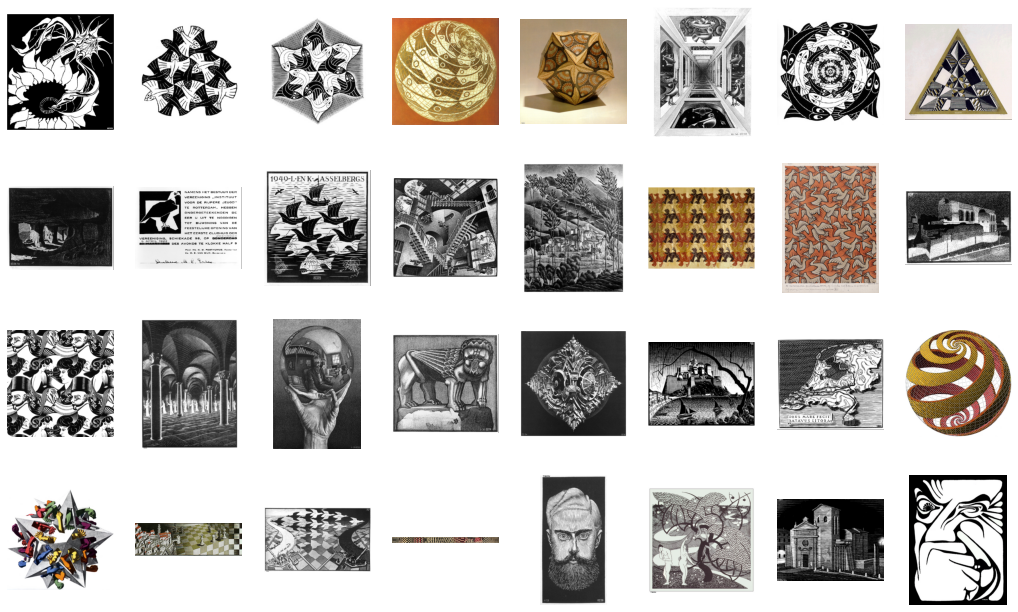

In [54]:
# Visualize a sample of the images
batch = next(iter(data_loader))
fig, axes = plt.subplots(4,8,figsize = (18,11))
for axis, image, label in zip(axes.flatten(), batch[0], batch[1]):
    image = image.permute(1,2,0)
    axis.imshow(image)
    axis.set_axis_off()

#### Finally, we generate some statistics with the enriched data

In [51]:
# Import enriched dataset information
train_info_enriched = pd.read_csv('train_info_enriched.csv')

all_info = pd.read_csv('all_data_info.csv')

def get_dataset_size(path):
    size = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                size += entry.stat().st_size
            elif entry.is_dir():
                size += get_dataset_size(entry.path)
    return size

# Help function to find extrema in the resolution
def find_extreme_res(df, kind='max'):
    res = df['pixels'].max() if kind == 'max' else df['pixels'].min()
    res_dim = df[df['pixels'] == res].iloc[0]['dimensions']
    return res, res_dim

# Find maximum, minimum, and average resolution of the images in the training dataset
max_res_train, max_res_train_dim = find_extreme_res(train_info_enriched, 'max')
min_res_train, min_res_train_dim = find_extreme_res(train_info_enriched, 'min')
mean_res_train = train_info_enriched['pixels'].mean()

# Count how many artists only have one artwork in the dataset
artist_counts = pd.DataFrame(train_info_enriched['artist'].value_counts())

artist_counts_single = len(artist_counts[artist_counts['artist'] == 1])
print(f'Total number of artworks: {len(all_info)}')
print(f'Number of artworks in the training set: {len(dataset)}')
print(f'Number of artworks in the test set: {len(all_info[all_info["in_train"] == False])}')
print(f'Number of unique artists in the training set: {len(artist_counts)}')
print(f'Minimum amount of artworks by an artist: {int(artist_counts.min())}')
print(f'Maximum amount of artworks by an artist: {int(artist_counts.max())}')
print(f'Maximum image resolution: {max_res_train} {max_res_train_dim}')
print(f'Minimum image resolution: {min_res_train} {min_res_train_dim}')
print(f'Average image resolution: {round(mean_res_train)} {(round(np.sqrt(mean_res_train)), round(np.sqrt(mean_res_train)))}')
print(f'Total dataset size: {round(get_dataset_size("train") / (2**30),1)}GB')

Total number of artworks: 103250
Number of artworks in the training set: 79433
Number of artworks in the test set: 23817
Number of unique artists in the training set: 1584
Minimum amount of artworks by an artist: 4
Maximum amount of artworks by an artist: 413
Maximum image resolution: 888150000 (29605, 30000)
Minimum image resolution: 70500 (300, 235)
Average image resolution: 1488578 (1220, 1220)
Total dataset size: 36.4GB


C:\Users\Andreas\AppData\Local\Temp\ipykernel_12672\2233018742.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  hist.set_xticklabels(['{:,.1f}'.format(x / 1e6) + 'M' for x in hist.get_xticks()])


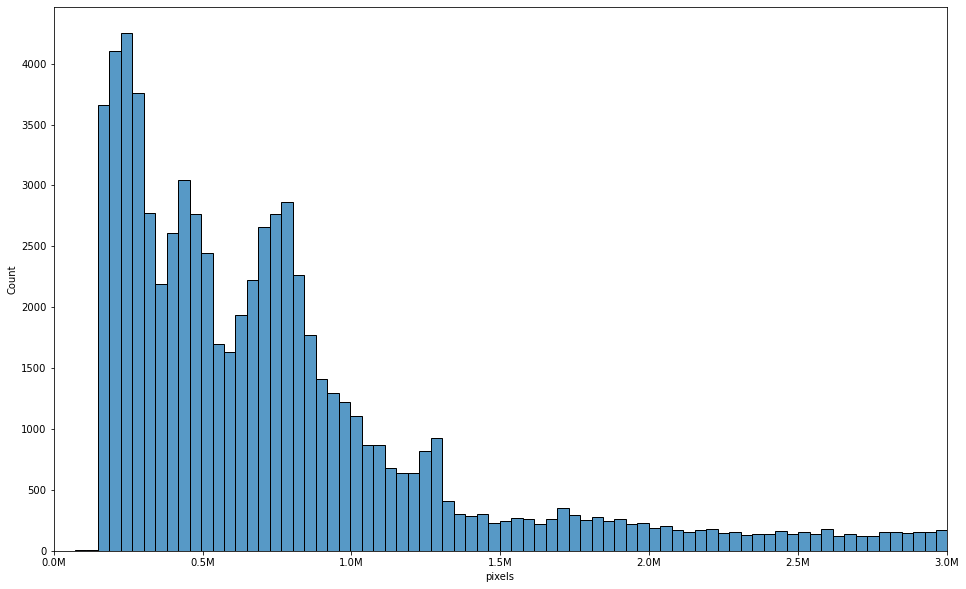

In [35]:
# Histogram showing distribution of image resolution
plt.figure(figsize= (16,10))
plt.xlim([0,3000000])
hist = sns.histplot(data=train_info_enriched, x='pixels')
hist.ticklabel_format(style='plain')
hist.set_xticklabels(['{:,.1f}'.format(x / 1e6) + 'M' for x in hist.get_xticks()])
plt.show()

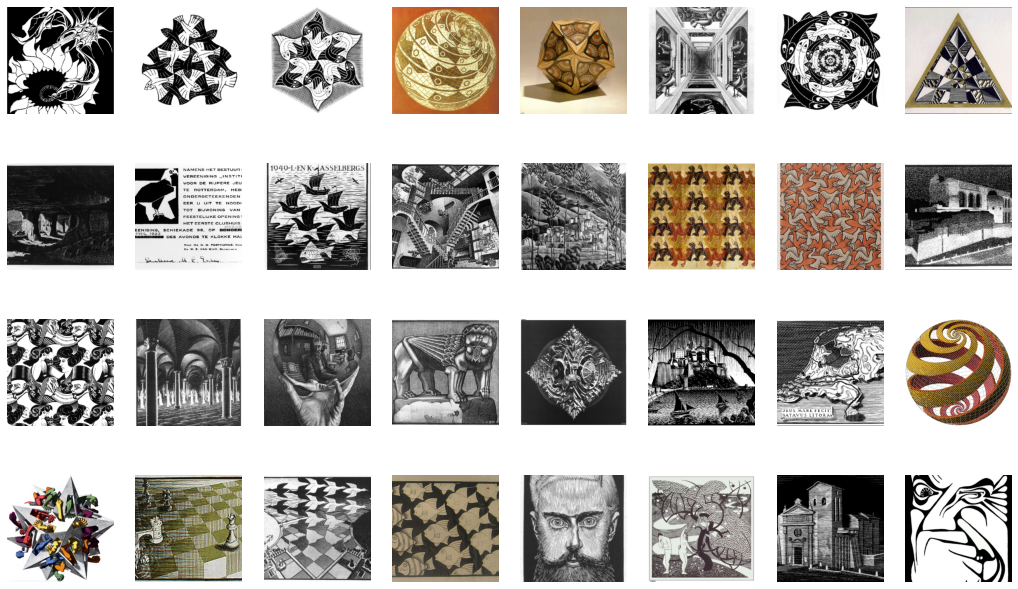

In [36]:
# Visualize a sample of the cropped and resized images
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(384), transforms.CenterCrop(384)])

dataset = datasets.ImageFolder('train', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

batch = next(iter(data_loader))
fig, axes = plt.subplots(4,8,figsize = (18,11))
for axis, image, label in zip(axes.flatten(), batch[0], batch[1]):
    image = image.permute(1,2,0)
    axis.imshow(image)
    axis.set_axis_off()